# Импортирование библиотек.

In [20]:
import cv2
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers, losses, optimizers
from keras import callbacks
from sklearn.ensemble import RandomForestClassifier

# Получение данных.

In [3]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [24]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

# Предварительная обработка данных.

Разделение набора данных на необходимые части.

In [6]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

Разделение пикселей изображения и меток для каждых данных на три набора.

In [7]:
num_classes = 7
input_shape = (48, 48, 3)

def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1)
  labels = data['emotion'].to_numpy()

  return images, labels

In [8]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

# Определение генератора изображений для увеличения данных.

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    fill_mode='nearest'
)

# Создание модели CNN

Реализация архитектуры модели.

In [10]:
model = Sequential()

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

Компиляция модели.

In [11]:
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 256)       295168    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 24, 24, 128)       35200     
 eConv2D)                                                        
                                                        

Определение параметров обратного вызова для модели для сохранения лучшего, выбор скорости обучения и ранняя остановка в случае снижения или статической производительности.

In [13]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

Обучение модели на тренировочном наборе данных.

In [14]:
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=64),
    epochs=35,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/35
449/449 [==============================] - 54s 94ms/step - loss: 1.8171 - accuracy: 0.2722 - val_loss: 2.0096 - val_accuracy: 0.2530 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/35
449/449 [==============================] - 47s 104ms/step - loss: 1.6423 - accuracy: 0.3525 - val_loss: 1.5821 - val_accuracy: 0.3901 - lr: 0.0010
Epoch 3/35
449/449 [==============================] - 38s 84ms/step - loss: 1.4880 - accuracy: 0.4240 - val_loss: 1.3649 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 4/35
449/449 [==============================] - 38s 84ms/step - loss: 1.3575 - accuracy: 0.4835 - val_loss: 1.2623 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 5/35
449/449 [==============================] - 39s 86ms/step - loss: 1.2632 - accuracy: 0.5192 - val_loss: 1.1889 - val_accuracy: 0.5497 - lr: 0.0010
Epoch 6/35
449/449 [==============================] - 37s 83ms/step - loss: 1.2133 - accuracy: 0.5364 - val_loss: 1.1610 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 7/35
449/449 [==============================] - 37s 82ms/step - loss: 1.1607 - accuracy: 0.5613 - val_loss: 1.1067 - val_accuracy: 0.5709 - lr: 0.0010
Epoch 8/35
449/449 [==============================] - 37s

In [15]:
model.save('emotion_detector.h5')

# Мониторинг производительности модели.

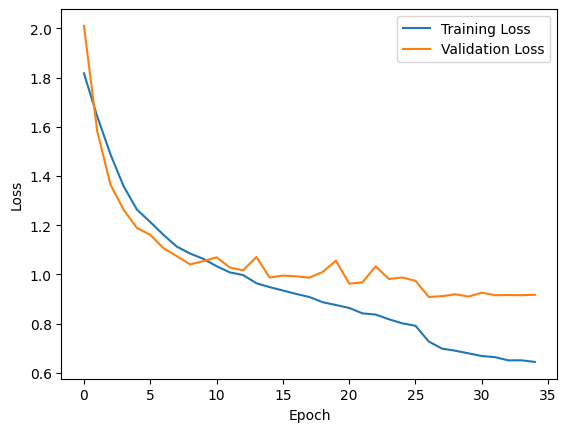

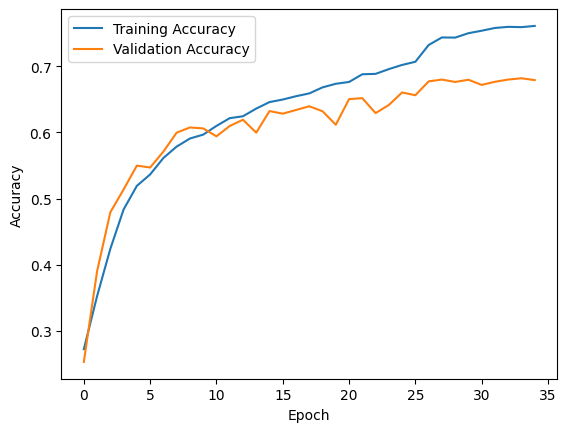

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()